In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
header = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [6]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [7]:
n_split = 20000
ratings_train = ratings[n_split:]
ratings_val = ratings[:n_split]
len(ratings_train), len(ratings_val)

(80000, 20000)

In [8]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1682 943 1650


In [9]:
max_rating = ratings_train['rating'].max()
min_rating = ratings_train['rating'].min()
av_rating = ratings_train['rating'].mean()
max_rating, min_rating, av_rating

(5, 1, 3.52835)

In [10]:
from keras.layers import Input, Embedding, Flatten, Dropout, Concatenate, Dense, Activation, Lambda
from keras import Model
from keras.regularizers import l2
from keras.optimizers import Adam

Using TensorFlow backend.


In [11]:
# Diferencia: las dimensiones de los Latent factors pueden ser distintos
n_latent_factors_user = 5
n_latent_factors_movie = 8

In [12]:
movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding', embeddings_regularizer = l2(0.001))(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
# movie_vec = Dropout(0.2)(movie_vec)


user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 
                                                  n_latent_factors_user,name='User-Embedding')(user_input))
# user_vec = Dropout(0.2)(user_vec)


concat = Concatenate(name='Concat')([movie_vec, user_vec])
# concat = Dropout(0.2)(concat)

x = Dense(50,name='FullyConnected-1', activation='relu')(concat)
#x = Dropout(0.5)(x)
#x = Dense(50,name='FullyConnected-1', activation='relu')(concat)
#x = Dropout(0.5)(x)


## Se pueden sacar las siguientes dos lineas para no forzar a sigmoidea
x = Dense(1, activation='sigmoid',name='Activation')(x)
x = Lambda(lambda z: (max_rating - min_rating) * z + min_rating)(x)
##

model = Model([user_input, movie_input], x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User[0][0]                       
____________________________________________________________________________________________

In [13]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [14]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [15]:
adam = Adam(lr=0.001)
model.compile(optimizer=adam,loss= 'mean_squared_error', metrics=[root_mean_squared_error])

In [16]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True, monitor='val_root_mean_squared_error')

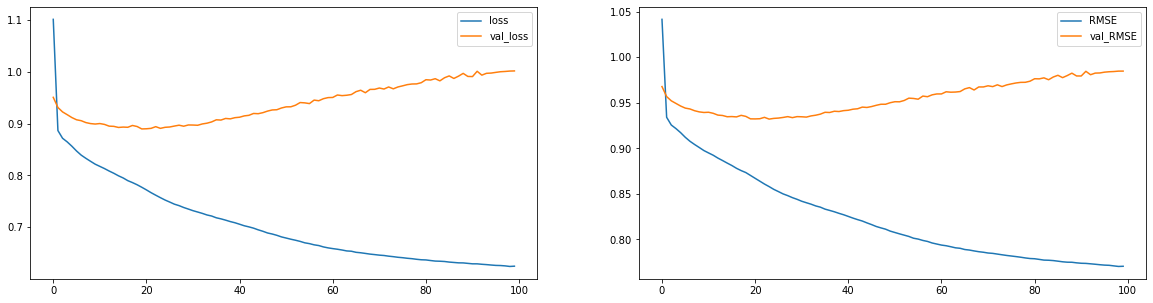


Epoch 00100: val_root_mean_squared_error did not improve from 0.93202


In [17]:
history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    batch_size = 320,
                    callbacks = [plot_losses, checkpointer],
                    epochs=100, verbose=1)

In [18]:
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

20000/20000 [==============================] - 1s 63us/step


[1.0019774771690368, 0.9755554795265198]

In [19]:
model.load_weights('weights.hdf5')
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

20000/20000 [==============================] - 1s 66us/step


[0.891041978931427, 0.9246664047241211]

# Ventajas de esta técnica
Muy simple agregar mas parámetros para la estimación

In [20]:
header = ['movieId', 'movieTitle', 'release date', 'video release date',
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
              "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']
items = pd.read_csv('./ml-100k/u.item', sep='|', encoding = "ISO-8859-1", names=header)
items

,movieId,movieTitle,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
users_data = pd.read_csv('./ml-100k/u.user', sep='|')
users_data

,1,24,M,technician,85711
0,2,53,F,other,94043
1,3,23,M,writer,32067
2,4,24,M,technician,43537
3,5,33,F,other,15213
4,6,42,M,executive,98101
...,...,...,...,...,...
937,939,26,F,student,33319
938,940,32,M,administrator,02215
939,941,20,M,student,97229
940,942,48,F,librarian,78209
